## <center>Прогноз просрочки кредита заемщиком</center>

Некоторые пункты задания переставлены, чтобы не нарушать логику обработки.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 80)

from tqdm import tqdm_notebook as tqdm
import gc
import pickle

import pandas_profiling

from sklearn.metrics import (roc_auc_score, f1_score, confusion_matrix,
                             classification_report, make_scorer)
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, QuantileTransformer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.model_selection import validation_curve, learning_curve

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt.pyll import scope as ho_scope

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
from matplotlib import pyplot as plt
#plt.style.use(['seaborn-darkgrid'])
#plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

RANDOM_STATE = 17

### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __MonthlyIncome__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [2]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [3]:
df = pd.read_csv('data/cs-training.csv', index_col=0)

In [4]:
#%%time
#report = pandas_profiling.ProfileReport(df, style={'full_width':True},
#                                        samples={'head':6, 'tail':6},
#                                        notebook={'iframe':{'height':'600px'}})
#report.to_file('profile_report.html')

In [4]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
print(df.shape)
df.describe(include = "all").T

(150000, 11)


,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [6]:
df.shape

(150000, 11)

In [7]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [8]:
df.rename(columns=lambda x: x.replace('-', '_'), inplace=True)
feature_names = df.columns[1:]

In [9]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30_59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60_89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [10]:
df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30_59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60_89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

**Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?**

In [11]:
print('Процент вернувших и не вернувших кредит:')
print(df.SeriousDlqin2yrs.value_counts(normalize=True) * 100)

Процент вернувших и не вернувших кредит:
0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64


Данные сильно несбалансированы. В качестве метрик лучше использовать `f1_score`, `roc_auc_score`. 

__Визуализация данных__

Используя  seaborn.pairplot (sns) визуализируйте данные

In [13]:
#%%time
#sns.pairplot(df, hue="SeriousDlqin2yrs", height=3);

**Используя sns.heatmap постройте корреляционную матрицу**

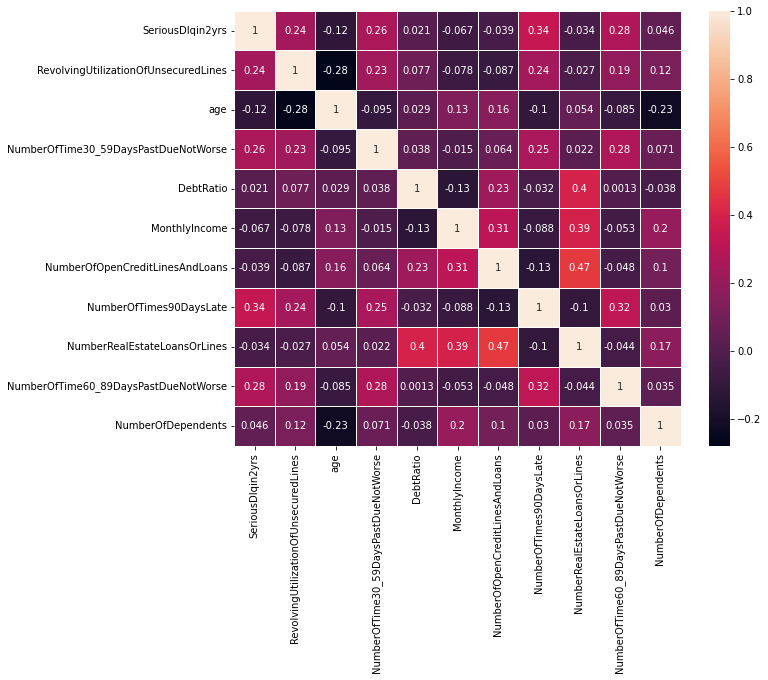

In [14]:
plt.figure(figsize=(10,8))
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True, linewidths=1);

**Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!**

Зависимости: вероятность просрочки находится в обратной зависимости от значений практически всех переменных кроме значений переменных с информацией о различных по времени просрочках, что логично.

Распределение переменной переменной `age` близко к нормальному. К переменным `RevolvingUtilizationOfUnsecuredLines`, `NumberOfOpenCreditLinesAndLoans`, `NumberOfDependents`, `MonthlyIncome` 
стоит применить логарифмирование. На распределения переменных с информацией о днях просрочки сильно влияет наличие "выбросов".

Корреляции из значимых:

- обратная корреляция `age` и `NumberOfDependents`;
- прямая корреляция `MonthlyIncome` и `NumberOfDependents`;
- высокая прямая корреляция `NumberOfOpenCreditLinesAndLoans` и `NumberRealEstateLoansOrLines`;
- высокая прямая корреляция `NumberRealEstateLoansOrLines` с `DebtRatio` и `MonthlyIncome`;
- прямая корреляция между количеством различных открытых кредитных линий (переменные `NumberOfOpenCreditLinesAndLoans` и `NumberRealEstateLoansOrLines`) и `MonthlyIncome`;
- прямая корреляция между переменными с информацией о различных по времени просрочках (`NumberOfTime30_59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate` и `NumberOfTime60_89DaysPastDueNotWorse`)
- обратная корреляция `RevolvingUtilizationOfUnsecuredLines` с `age` и прямая корреляция с переменными с информацией о различных по времени просрочках.

**Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам**

Категориальных признаков нет (df.info() показывает только числовые типы переменных). 

Соответствие содержимого данных их типам вызывает **вопросы**: 

1. Максимальное значение переменных `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate` и `NumberOfTime60-89DaysPastDueNotWorse` - это одинаковое число **98**, этот момент требует более детального рассмотрения.

2. Если `DebtRatio` - это сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход, то каким образом эта переменная расчитывалась в случае пропусков значения `MonthlyIncome`?

3. Переменные `RevolvingUtilizationOfUnsecuredLines` и  `DebtRatio`, которые согласно описанию измеряются в процентах, имеют максимальные значения **50708.0** и **329664.0** соответственно, хотя не должны быть больше **1**.

#### 1. `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate` и `NumberOfTime60-89DaysPastDueNotWorse`

In [15]:
len(df[df.NumberOfTime30_59DaysPastDueNotWorse > 97])
len(df[df.NumberOfTimes90DaysLate > 97])
len(df[df.NumberOfTime60_89DaysPastDueNotWorse > 97])
len(df[(df.NumberOfTimes90DaysLate > 97) & 
       (df.NumberOfTime30_59DaysPastDueNotWorse > 97) & 
       (df.NumberOfTime60_89DaysPastDueNotWorse > 97)])

264

264

264

264

In [16]:
df[df.NumberOfTimes90DaysLate > 97].head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
1734,1,1.0,27,98,0.0,2700.0,0,98,0,98,0.0
2287,0,1.0,22,98,0.0,NaN,0,98,0,98,0.0
3885,0,1.0,38,98,12.0,NaN,0,98,0,98,0.0
4418,0,1.0,21,98,0.0,0.0,0,98,0,98,0.0
4706,0,1.0,21,98,0.0,2000.0,0,98,0,98,0.0


In [17]:
df.NumberOfTime30_59DaysPastDueNotWorse.value_counts().sort_index()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: NumberOfTime30_59DaysPastDueNotWorse, dtype: int64

In [18]:
df.NumberOfTimes90DaysLate.value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

In [19]:
df.NumberOfTime60_89DaysPastDueNotWorse.value_counts().sort_index()

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60_89DaysPastDueNotWorse, dtype: int64

Максимальные значения переменных `NumberOfTime30_59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate` и `NumberOfTime60_89DaysPastDueNotWorse` (**98**) относятся к одним и тем же наблюдениям. Также в этих переменных присутствует значение **96**, и тоже в одинаковых количествах.

In [20]:
df_higher96 = df[df['NumberOfTimes90DaysLate'] > 95][[
    'NumberOfTime30_59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
    'NumberOfTime60_89DaysPastDueNotWorse', 'SeriousDlqin2yrs'
]]
df_higher96.describe()

,NumberOfTime30_59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60_89DaysPastDueNotWorse,SeriousDlqin2yrs
count,269.000000,269.000000,269.000000,269.000000
mean,97.962825,97.962825,97.962825,0.546468
std,0.270628,0.270628,0.270628,0.498764
min,96.000000,96.000000,96.000000,0.000000
25%,98.000000,98.000000,98.000000,0.000000
50%,98.000000,98.000000,98.000000,1.000000
75%,98.000000,98.000000,98.000000,1.000000
max,98.000000,98.000000,98.000000,1.000000


In [21]:
df_higher96.SeriousDlqin2yrs.value_counts()

1    147
0    122
Name: SeriousDlqin2yrs, dtype: int64

Больше половины выделенных наблюдений имеют значение целевой переменной `SeriousDlqin2yrs` **1** (миноритарный класс), поэтому можно использовать эти переменные для создания новых переменных.

In [22]:
# Все сведения о просрочках для наблюдения
df['NumberOfTimes_PastDue'] = (df.NumberOfTime30_59DaysPastDueNotWorse + 
                              df.NumberOfTimes90DaysLate + 
                              df.NumberOfTime60_89DaysPastDueNotWorse)

In [23]:
# Высокие значения просрочек
df['NumberOfTimesLate_high'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse > 95, 1, 0).astype('object')
#df['no_creditInfo'] = df['no_creditInfo'].astype('object')
# Значения == 96
df['NumberOfTimesLate_96'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse == 96, 1, 0).astype('object')
# Значения == 98
df['NumberOfTimesLate_98'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse == 98, 1, 0).astype('object')

# Отсутствие просрочек на данный срок
df['NumberOfTime30_59Days_none'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse == 0, 1, 0).astype('object')
df['NumberOfTimes90Days_none'] = np.where(df.NumberOfTimes90DaysLate == 0, 1,
                                          0).astype('object')
df['NumberOfTime60_89Days_none'] = np.where(
    df.NumberOfTime60_89DaysPastDueNotWorse == 0, 1, 0).astype('object')

In [24]:
# Самое высокое значение, исключая 96 и 98, для NumberOfTimes90DaysLate == 17
# RandomForest устойчив к выбросам, но для других моделей,
# возможно, стоит уменьшить диапазон значений
# Заменяем значения 96 и 98 на 20
df.NumberOfTime30_59DaysPastDueNotWorse[
    df.NumberOfTime30_59DaysPastDueNotWorse > 95] = 20
df.NumberOfTimes90DaysLate[
    df.NumberOfTime30_59DaysPastDueNotWorse > 95] = 20
df.NumberOfTime60_89DaysPastDueNotWorse[
    df.NumberOfTime60_89DaysPastDueNotWorse > 95] = 20

In [25]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,NumberOfTimesLate_high,NumberOfTimesLate_96,NumberOfTimesLate_98,NumberOfTime30_59Days_none,NumberOfTimes90Days_none,NumberOfTime60_89Days_none
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,2,0,0,0,0,1,1
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0,0,0,1,1,1
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,2,0,0,0,0,0,1
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0,0,0,1,1,1
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1,0,0,0,0,1,1


Наша задача на данном шаге кроме создания новых переменных по возмождности сохранить информацию из переменных которые были у нас ранее. Мы бы могли удалить все "выбросы" но на данном этапе мы пока что не знам что есть выброс.

#### 2. `DebtRatio` и `MonthlyIncome`

In [26]:
df.DebtRatio.value_counts().sort_index()

0.000000         4113
0.000026            1
0.000037            1
0.000039            1
0.000066            1
                 ... 
168835.000000       1
220516.000000       1
307001.000000       1
326442.000000       1
329664.000000       1
Name: DebtRatio, Length: 114194, dtype: int64

Посмотрим на значения `DebtRatio` при не определенном `MonthlyIncome`.

In [27]:
df.DebtRatio[df.MonthlyIncome.isna()].value_counts().sort_index()

0.0         1622
1.0          205
2.0          160
3.0          155
4.0          162
            ... 
168835.0       1
220516.0       1
307001.0       1
326442.0       1
329664.0       1
Name: DebtRatio, Length: 5728, dtype: int64

При пропущенных значениях `MonthlyIncome` значения `DebtRatio`равны нулю или больше 1.

Создадим промежуточную переменную, аналогичную `MonthlyIncome`, но с заполнением пропущенных значений **1**. 

In [28]:
df['MonthlyIncomeFilled'] = df.MonthlyIncome
df.MonthlyIncomeFilled.fillna(1, inplace=True)

Учитывая описание переменной `DebtRatio` можно создать переменную `MonthlyPayment`, показывающую **"сумму ежемесячных платежей по долгам, алиментов и расходов на проживание"** (числитель при расчете `DebtRatio`).

In [31]:
df['MonthlyPayment'] = df.DebtRatio * df.MonthlyIncomeFilled

In [32]:
df[['DebtRatio', 'MonthlyPayment', 'MonthlyIncomeFilled']]

,DebtRatio,MonthlyPayment,MonthlyIncomeFilled
1,0.802982,7323.197016,9120.0
2,0.121876,316.878123,2600.0
3,0.085113,258.914887,3042.0
4,0.036050,118.963951,3300.0
5,0.024926,1584.975094,63588.0
...,...,...,...
149996,0.225131,472.774869,2100.0
149997,0.716562,4001.283436,5584.0
149998,3870.000000,3870.000000,1.0
149999,0.000000,0.000000,5716.0


In [33]:
len(df[df['MonthlyPayment']==0.0])

5650

In [34]:
df['MonthlyPayment'].describe()

count    150000.000000
mean       2029.675384
std        4210.622764
min           0.000000
25%         510.744628
50%        1528.901456
75%        2787.698312
max      478450.559160
Name: MonthlyPayment, dtype: float64

Будем предполагать, что, если отсутствуют сведения о сумме ежемесячных платежей по долгам, алиментов и расходов на проживание, то, в соответствии с формулой расчета, `DebtRatio` равен **0**. Если же нет сведений о месячном доходе, то `DebtRatio` содержит значение ежемесячных платежей, и именно отсюда такие большие значения.

Возможно, эти рассуждения спорные, но введение переменной, показывающей месячные расходы, представляется нелишним шагом, который можно будет оценить на этапе моделирования.

In [35]:
df = df.drop('MonthlyIncomeFilled', axis=1)

In [37]:
df['MonthlyIncome_none'] = np.where(df.MonthlyIncome.isna(), 1,
                                    0).astype('object')
df['MonthlyIncome_zero'] = np.where(df.MonthlyIncome == 0.0, 1,
                                    0).astype('object')
df['DebtRatio_zero'] = np.where(df.DebtRatio == 0.0, 1, 0).astype('object')

In [38]:
# Заменяем несоответствующие расчету значения DebtRatio на 0
df.DebtRatio[df.DebtRatio > 1.0] = 0.0

#### 3. `RevolvingUtilizationOfUnsecuredLines`

In [39]:
df.RevolvingUtilizationOfUnsecuredLines.value_counts()

0.000000    10878
1.000000    10256
1.000000       17
0.950100        8
0.007984        6
            ...  
0.954162        1
0.820080        1
0.176771        1
0.084661        1
0.850283        1
Name: RevolvingUtilizationOfUnsecuredLines, Length: 125728, dtype: int64

Значение 1.000000 в списке присутствует 2 раза, второй раз это скорее всего результат округления числа близкого к 1.0. 

In [40]:
# Какие значения RevolvingUtilizationOfUnsecuredLines выше среднего
df.RevolvingUtilizationOfUnsecuredLines[
    df.RevolvingUtilizationOfUnsecuredLines > 6.048438].value_counts().sort_index()

# И сколько их
len(df.RevolvingUtilizationOfUnsecuredLines[
    df.RevolvingUtilizationOfUnsecuredLines > 6.048438])

6.425716        1
6.478840        1
7.308970        1
8.599600        1
8.851852        1
               ..
20514.000000    1
22000.000000    1
22198.000000    1
29110.000000    1
50708.000000    1
Name: RevolvingUtilizationOfUnsecuredLines, Length: 243, dtype: int64

246

In [41]:
df[df.RevolvingUtilizationOfUnsecuredLines > 1].SeriousDlqin2yrs.describe()

count    3321.000000
mean        0.372478
std         0.483538
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: SeriousDlqin2yrs, dtype: float64

У переменной `RevolvingUtilizationOfUnsecuredLines` довольно высокая корреляция с `SeriousDlqin2yrs`. Количество значений переменной выше 1 составляет **3321**, т.е., **2.214 %** от всех данных.

Введем несколько дополнительных переменных.

In [42]:
df['RUUL_high'] = np.where(df.RevolvingUtilizationOfUnsecuredLines > 1, 1,
                           0).astype('object')
df['RUUL_zero'] = np.where(df.RevolvingUtilizationOfUnsecuredLines == 0, 1,
                           0).astype('object')
df['RUUL_ones'] = np.where(df.RevolvingUtilizationOfUnsecuredLines == 1, 1,
                           0).astype('object')

In [44]:
df.head()
df.shape

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,NumberOfTimesLate_high,NumberOfTimesLate_96,NumberOfTimesLate_98,NumberOfTime30_59Days_none,NumberOfTimes90Days_none,NumberOfTime60_89Days_none,MonthlyPayment,MonthlyIncome_none,MonthlyIncome_zero,DebtRatio_zero,RUUL_high,RUUL_zero,RUUL_ones
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,2,0,0,0,0,1,1,7323.197016,0,0,0,0,0,0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0,0,0,1,1,1,316.878123,0,0,0,0,0,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,2,0,0,0,0,0,1,258.914887,0,0,0,0,0,0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0,0,0,1,1,1,118.963951,0,0,0,0,0,0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1,0,0,0,0,1,1,1584.975094,0,0,0,0,0,0


(150000, 25)

**Проверьте наличие NaN, при необходимости осуществите замену**

In [45]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30_59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60_89DaysPastDueNotWorse        0
NumberOfDependents                       3924
NumberOfTimes_PastDue                       0
NumberOfTimesLate_high                      0
NumberOfTimesLate_96                        0
NumberOfTimesLate_98                        0
NumberOfTime30_59Days_none                  0
NumberOfTimes90Days_none                    0
NumberOfTime60_89Days_none                  0
MonthlyPayment                              0
MonthlyIncome_none                          0
MonthlyIncome_zero                          0
DebtRatio_zero                    

Кроме NaN стоит еще проверить нулевые значения.

In [46]:
(df == 0).sum(axis=0)

SeriousDlqin2yrs                        139974
RevolvingUtilizationOfUnsecuredLines     10878
age                                          1
NumberOfTime30_59DaysPastDueNotWorse    126018
DebtRatio                                39250
MonthlyIncome                             1634
NumberOfOpenCreditLinesAndLoans           1888
NumberOfTimes90DaysLate                 141662
NumberRealEstateLoansOrLines             56188
NumberOfTime60_89DaysPastDueNotWorse    142396
NumberOfDependents                       86902
NumberOfTimes_PastDue                   119637
NumberOfTimesLate_high                  149731
NumberOfTimesLate_96                    149995
NumberOfTimesLate_98                    149736
NumberOfTime30_59Days_none               23982
NumberOfTimes90Days_none                  8338
NumberOfTime60_89Days_none                7604
MonthlyPayment                            5650
MonthlyIncome_none                      120269
MonthlyIncome_zero                      148366
DebtRatio_zer

In [47]:
df[df.age==0]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,NumberOfTimesLate_high,NumberOfTimesLate_96,NumberOfTimesLate_98,NumberOfTime30_59Days_none,NumberOfTimes90Days_none,NumberOfTime60_89Days_none,MonthlyPayment,MonthlyIncome_none,MonthlyIncome_zero,DebtRatio_zero,RUUL_high,RUUL_zero,RUUL_ones
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0,1,0,0,0,0,1,1,2621.563074,0,0,0,0,0,0


In [48]:
# Вряд ли принципиально, на что заменить одно нулевое
# значение age при 150000 наблюдений, заменим просто модой
rep_age = df.age.mode()
df.age[df.age==0] = int(rep_age)

In [49]:
df.NumberOfDependents.mode()
df.NumberOfDependents.median()

0    0.0
dtype: float64

0.0

In [50]:
df['NumberOfDependents_none'] = np.where(
    df.NumberOfDependents.isna(), 1, 0).astype('object')

In [51]:
# Заменяем пропущенные значения NumberOfDependents 
# на 0 (и мода, и медиана)
df.NumberOfDependents.fillna(0, inplace=True)

In [52]:
gc.collect()

13346

**О чем свидетельствуют пропуски в данных, чем их лучше заменить? Осуществите необходимую замену.**

Для заполнения пропущенных значений `MonthlyIncome` применим `RandomForestRegressor`.

Перед заполнением разделяем датасет на обучающую и валидационную выборки.

In [53]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, valid_index in split.split(df, df.SeriousDlqin2yrs):
    X_train = df.iloc[train_index]    
    X_valid = df.iloc[valid_index]    

In [54]:
X_tr = X_train.drop('SeriousDlqin2yrs', axis=1)
y_tr = X_train.SeriousDlqin2yrs

X_val = X_valid.drop('SeriousDlqin2yrs', axis=1)
y_val = X_valid.SeriousDlqin2yrs

In [55]:
# Проверка качества разбиения
y_tr.value_counts(normalize=True) * 100
y_val.value_counts(normalize=True) * 100

0    93.31619
1     6.68381
Name: SeriousDlqin2yrs, dtype: float64

0    93.315556
1     6.684444
Name: SeriousDlqin2yrs, dtype: float64

In [56]:
X_tr.info()
X_tr.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105000 entries, 138986 to 80531
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  105000 non-null  float64
 1   age                                   105000 non-null  int64  
 2   NumberOfTime30_59DaysPastDueNotWorse  105000 non-null  int64  
 3   DebtRatio                             105000 non-null  float64
 4   MonthlyIncome                         84277 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       105000 non-null  int64  
 6   NumberOfTimes90DaysLate               105000 non-null  int64  
 7   NumberRealEstateLoansOrLines          105000 non-null  int64  
 8   NumberOfTime60_89DaysPastDueNotWorse  105000 non-null  int64  
 9   NumberOfDependents                    105000 non-null  float64
 10  NumberOfTimes_PastDue                 105000 non-null  int64  
 

(105000, 25)

In [57]:
list(feature_names).index('MonthlyIncome')

4

In [58]:
choose_cols = list(feature_names)
del choose_cols[4]

In [59]:
def fill_mi(data):
    data_mi = data.dropna()
    X_mi = data_mi[choose_cols]
    y_mi = data_mi.MonthlyIncome
    rf_fill = RandomForestRegressor(n_estimators=200).fit(X_mi, y_mi)
    
    X_fill_mi = data[data.MonthlyIncome.isna()]
    X_fill = rf_fill.predict(X_fill_mi[choose_cols])
    data.loc[data.MonthlyIncome.isna(), 'MonthlyIncome'] = X_fill
    return data

In [60]:
%%time
df_train = fill_mi(X_tr)

Wall time: 56.9 s


In [61]:
%%time
df_valid = fill_mi(X_val)

Wall time: 21.8 s


In [62]:
df_train.isna().sum().sum()
df_valid.isna().sum().sum()

0

0

In [63]:
#with open('data/df_train.pkl', 'wb') as file:  
#    pickle.dump(df_train, file)
#with open('data/df_valid.pkl', 'wb') as file:  
#    pickle.dump(df_valid, file)

In [64]:
with open('data/df_train.pkl', 'rb') as file:  
    df_train = pickle.load(file) 
with open('data/df_valid.pkl', 'rb') as file:  
    df_valid = pickle.load(file)

In [65]:
(df_train == 0).sum(axis=0)
(df_valid == 0).sum(axis=0)

RevolvingUtilizationOfUnsecuredLines      7688
age                                          0
NumberOfTime30_59DaysPastDueNotWorse     88178
DebtRatio                                27407
MonthlyIncome                             1147
NumberOfOpenCreditLinesAndLoans           1321
NumberOfTimes90DaysLate                  99103
NumberRealEstateLoansOrLines             39193
NumberOfTime60_89DaysPastDueNotWorse     99662
NumberOfDependents                       63503
NumberOfTimes_PastDue                    83730
NumberOfTimesLate_high                  104818
NumberOfTimesLate_96                    104999
NumberOfTimesLate_98                    104819
NumberOfTime30_59Days_none               16822
NumberOfTimes90Days_none                  5897
NumberOfTime60_89Days_none                5338
MonthlyPayment                            3986
MonthlyIncome_none                       84277
MonthlyIncome_zero                      103854
DebtRatio_zero                          102092
RUUL_high    

RevolvingUtilizationOfUnsecuredLines     3190
age                                         0
NumberOfTime30_59DaysPastDueNotWorse    37840
DebtRatio                               11843
MonthlyIncome                             489
NumberOfOpenCreditLinesAndLoans           567
NumberOfTimes90DaysLate                 42559
NumberRealEstateLoansOrLines            16995
NumberOfTime60_89DaysPastDueNotWorse    42734
NumberOfDependents                      27323
NumberOfTimes_PastDue                   35907
NumberOfTimesLate_high                  44913
NumberOfTimesLate_96                    44996
NumberOfTimesLate_98                    44917
NumberOfTime30_59Days_none               7160
NumberOfTimes90Days_none                 2441
NumberOfTime60_89Days_none               2266
MonthlyPayment                           1664
MonthlyIncome_none                      35992
MonthlyIncome_zero                      44512
DebtRatio_zero                          43795
RUUL_high                         

In [66]:
df_train.shape
df_valid.shape

(105000, 25)

(45000, 25)

__Предобработка данных__

Оцените распределение признаков. Удалите коррелированные! Выберите способ нормализации. Подготовьте данные для обучения выбранных моделей.

После удаления коррелированных признаков значения итоговых метрик стали хуже, поэтому переменные были восстановлены и дальше обработка идет без удаления коррелированных. 

In [67]:
col = df_valid.columns[:10]

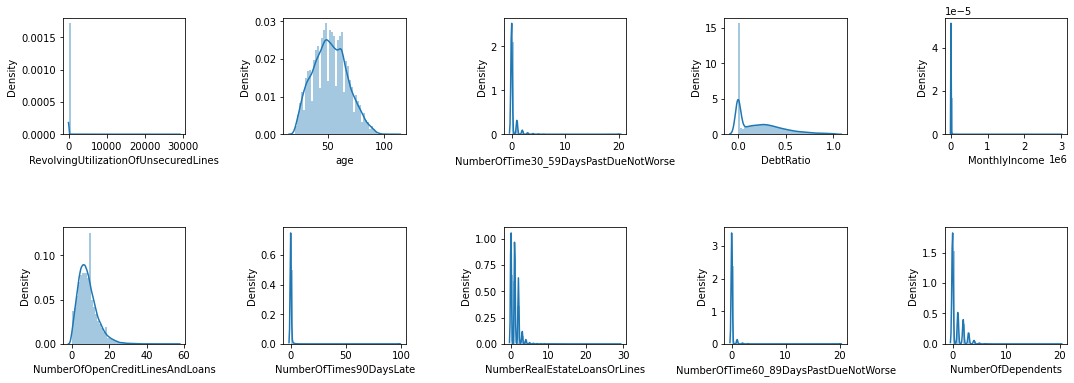

In [68]:
fig , ax = plt.subplots(2,5,figsize=(18,6))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
k=0;
for i in col:
    axes = sns.distplot(df_valid[i], ax=ax[k//5,k%5])
    axes.set(xlabel=i)
    k += 1
pass;

Числовые признаки будем масштабировать хорошо зарекомендовавшим себя для таких случаев `QuantileTransformer`.

In [69]:
cat_columns = [i for i in df_train.columns if 
               df_train[i].dtype.name=='category' or 
               df_train[i].dtype.name=='object']
num_columns = [i for i in df_train.columns if 
               df_train[i].dtype.name=='float64' or 
               df_train[i].dtype.name=='int64']

In [70]:
df_train_num = df_train[num_columns]

In [71]:
qtf = QuantileTransformer(output_distribution='normal')
qtf.fit(df_train_num)

QuantileTransformer(output_distribution='normal')

In [72]:
def preproc(data, trans):
    data_cat = pd.get_dummies(data[cat_columns])
    data_norm = data[num_columns]
    data_norm[num_columns] = trans.transform(data[num_columns])
    data_all = pd.concat((data_norm, data_cat), axis=1)
    return data_all    

In [73]:
X_train_qt = preproc(df_train, qtf)
X_valid_qt = preproc(df_valid, qtf)

In [74]:
X_train_qt.shape
X_train_qt.head()

(105000, 38)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,MonthlyPayment,NumberOfTimesLate_high_0,NumberOfTimesLate_high_1,NumberOfTimesLate_96_0,NumberOfTimesLate_96_1,NumberOfTimesLate_98_0,NumberOfTimesLate_98_1,NumberOfTime30_59Days_none_0,NumberOfTime30_59Days_none_1,NumberOfTimes90Days_none_0,NumberOfTimes90Days_none_1,NumberOfTime60_89Days_none_0,NumberOfTime60_89Days_none_1,MonthlyIncome_none_0,MonthlyIncome_none_1,MonthlyIncome_zero_0,MonthlyIncome_zero_1,DebtRatio_zero_0,DebtRatio_zero_1,RUUL_high_0,RUUL_high_1,RUUL_zero_0,RUUL_zero_1,RUUL_ones_0,RUUL_ones_1,NumberOfDependents_none_0,NumberOfDependents_none_1
138986,-5.199338,-0.176553,-5.199338,-0.187754,0.184203,-0.625670,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-0.554657,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0
63965,-0.632357,-0.965420,-5.199338,0.817992,-0.520661,-0.899534,-5.199338,0.121995,-5.199338,0.504922,-5.199338,-0.210585,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
46078,-1.096386,-0.832006,-5.199338,1.613818,-0.346817,0.641002,-5.199338,0.121995,-5.199338,-5.199338,-5.199338,0.418345,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
83031,0.692020,0.312376,-5.199338,0.456579,1.820042,1.116369,-5.199338,2.119668,-5.199338,-5.199338,-5.199338,1.465504,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
11185,0.750159,-1.102440,-5.199338,1.180185,0.493553,0.276998,-5.199338,1.689670,-5.199338,0.504922,-5.199338,0.982349,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0


__Выбор метрики__

В качестве метрики используется ROC-AUC score, согласно соренованию. Данная метрика подходит для данной задачи, так как мы хотим определять тех заемщиков, которые сильно задержат выплату кредита, но при этом выдавать кредиты хорошим клиентам. Также эта метрика хорошо работает со случаем несбалансированных классов (как в нашем случае).
Выберите способ перекрестной проверки! Какой из них подходит наилучшим образом...

In [75]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

**Обучите 2 классификатора логистическую регрессию и случайный лес.
Оцените среднюю правильность выбранной модели.**

**LogisticRegression**

In [76]:
%%time
logit = LogisticRegression(class_weight='balanced', n_jobs=-1)
logit.fit(X_train_qt, y_tr)

Wall time: 6.52 s


LogisticRegression(class_weight='balanced', n_jobs=-1)

In [77]:
%%time
scores_logit = cross_val_score(logit, X_train_qt, y_tr, 
                               scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки: {}".format(scores_logit))
scores_logit.mean()

Значения правильности перекрестной проверки: [0.86483045 0.85609838 0.85544887 0.84802636 0.84111721 0.8471134
 0.87181959 0.85128397 0.85958004 0.8531647 ]
Wall time: 57 s


0.8548482958258182

**RandomForestClassifier**

In [78]:
%%time
rf = RandomForestClassifier(class_weight='balanced_subsample', 
                            n_jobs=-1, random_state=2020)
rf.fit(X_train_qt, y_tr)

Wall time: 2.83 s


RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=2020)

In [79]:
%%time
scores_rf = cross_val_score(rf, X_train_qt, y_tr, 
                            scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки: {}".format(scores_rf))
scores_rf.mean()

Значения правильности перекрестной проверки: [0.84854477 0.83904876 0.84411937 0.82818431 0.81654427 0.8325899
 0.85488862 0.83695361 0.84542364 0.83257696]
Wall time: 25.3 s


0.8378874204559388

In [80]:
gc.collect()

2884

__Кросс-валидация и подбор параметров__

Произведите подбор параметров. Для логистической регрессии подберем коэффициент регуляризции, для случайного леса -максимальную глубину и максимальное кол-во признаков. Для отслеживания процесса обучения используйте прогрессбар, а также %%time

In [595]:
skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [596]:
ftwo_scorer = make_scorer(roc_auc_score, needs_proba=True)

In [597]:
%%time
def hyperopt_forest_score(params):
    clf = RandomForestClassifier(
        **params,
        random_state=42,
        class_weight='balanced_subsample',
        n_jobs=-1)
    
    current_score = cross_val_score(
        clf, X_train_qt, y_tr, scoring=ftwo_scorer, cv=skf5).mean()
    print(current_score, params)
    return -current_score

space_forest = {
    'max_depth': hp.choice('max_depth', range(2, 20)),
    'n_estimators': ho_scope.int(hp.quniform('n_estimators', 300, 1500, 3)),
    'max_features': hp.choice('max_features',['sqrt', 'log2', 
                                       X_train_qt.shape[1]])
}

best = fmin(
    fn=hyperopt_forest_score,
    space=space_forest,
    algo=tpe.suggest,
    max_evals=25)
print('best:')
print(best)

0.8576655741082755                                                             
{'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 864}                 
0.8596222243809789                                                             
{'max_depth': 5, 'max_features': 38, 'n_estimators': 477}                      
0.8525681340874351                                                             
{'max_depth': 11, 'max_features': 38, 'n_estimators': 846}                     
0.8520089344308619                                                             
{'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 672}                 
0.8584179971237533                                                             
{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 579}                  
0.8369136655295698                                                             
{'max_depth': 19, 'max_features': 'sqrt', 'n_estimators': 903}                 
0.8593394259584384                      

Предыдущие запуски `hyperopt` тоже показывали лучший результат для всего набора признаков, поэтому этот параметр установим сразу, подберем `criterion` и увеличим количество папок.

In [605]:
%%time
def hyperopt_forest_score(params):
    clf = RandomForestClassifier(
        **params,
        random_state=42,
        class_weight='balanced_subsample',
        max_features=X_train_qt.shape[1],
        n_jobs=-1)
    
    current_score = cross_val_score(
        clf, X_train_qt, y_tr, scoring=ftwo_scorer, cv=skf).mean()
    
    print(current_score, params)
    return -current_score

space_forest = {
    'max_depth': hp.choice('max_depth', range(2, 20)),
    'n_estimators': ho_scope.int(hp.quniform('n_estimators', 
                                             500, 1600, 3)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

best = fmin(
    fn=hyperopt_forest_score,
    space=space_forest,
    algo=tpe.suggest,
    max_evals=25)
print('best:')
print(best)

0.8600749262699555                                                             
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 1002}                 
0.8403582557726036                                                             
{'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 537}                 
0.8562139621636925                                                             
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 1458}                
0.8599034098847028                                                             
{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 999}                     
0.8607535270623833                                                             
{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 1275}                    
0.8597718860797675                                                             
{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 1413}                 
0.8607910481605622                      

In [602]:
%%time
def hyperopt_logit_score(params):
    clf = LogisticRegression(**params, class_weight='balanced', n_jobs=-1)
    
    current_score = cross_val_score(
        clf, X_train_qt, y_tr, scoring=ftwo_scorer, cv=skf).mean()
    print(current_score, params)
    return -current_score

logit_space = {
    'C': hp.loguniform('C', -4.0 * np.log(10.0), 4.0 * np.log(10.0))
}

best = fmin(
    fn=hyperopt_logit_score, space=logit_space, algo=tpe.suggest, max_evals=30)
print('best:')
print(best)

0.8550139560248571                                                             
{'C': 0.03628601924008826}                                                     
0.854936909622016                                                              
{'C': 0.5806468115576792}                                                      
0.8548223274255242                                                             
{'C': 400.1594703912052}                                                       
0.854847476231012                                                              
{'C': 504.3382786810999}                                                       
0.8550269710018146                                                             
{'C': 0.043335608458044864}                                                    
0.8546634521315191                                                             
{'C': 0.009893370226722095}                                                    
0.8548614271196577                      

**Отобразите результаты обучения модели**

In [606]:
%%time
rf_par = RandomForestClassifier(class_weight='balanced_subsample', 
                                max_depth=6, criterion='entropy', 
                                max_features=X_train_qt.shape[1], 
                                n_estimators=1164, n_jobs=-1, 
                                random_state=2020)
rf_par.fit(X_train_qt, y_tr)

Wall time: 1min


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, max_features=38, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1164, n_jobs=-1, oob_score=False,
                       random_state=2020, verbose=0, warm_start=False)

In [607]:
%%time
scores_rf_par = cross_val_score(rf_par, X_train_qt, y_tr, 
                                scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки после подбора "
      "параметров RandomForestClassifier: {}".format(scores_rf_par))
scores_rf_par.mean()

Значения правильности перекрестной проверки после подбора параметров RandomForestClassifier: [0.87229148 0.8618163  0.8640166  0.85251503 0.84702762 0.85304686
 0.87748365 0.85237895 0.86444963 0.8630276 ]
Wall time: 9min 48s


0.860805372200087

In [726]:
%%time
logit_par = LogisticRegression(class_weight='balanced', n_jobs=-1,
                               C=0.08803411562934406)
logit_par.fit(X_train_qt, y_tr)

Wall time: 6.95 s


LogisticRegression(C=0.08803411562934406, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [727]:
%%time
scores_logit_par = cross_val_score(logit_par, X_train_qt, y_tr, 
                                   scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки после подбора "
      "параметра 'C' LogisticRegression: {}".format(scores_logit_par))
scores_logit_par.mean()

Значения правильности перекрестной проверки после подбора параметра 'C' LogisticRegression: [0.86481488 0.85631136 0.85614498 0.84804729 0.84096978 0.84709159
 0.8719798  0.85270789 0.85951011 0.85315641]
Wall time: 59.7 s


0.8550734100243753

**Какая из моделей показала наилучшие результаты? Отобразите подобранные параметры.**

Если до подбора параметров `LogisticRegression` показывала результат лучше, чем `RandomForestClassifier`, то после подбора ситуация стала обратной.

Лучшие параметры для `RandomForestClassifier`:
* 'max_depth' = 6, 
* 'criterion'-'entropy',
* 'max_features' - все признаки, 
* 'n_estimators' = 1164.

Лучший параметр C=0.08803411562934406 для `LogisticRegression`.

In [728]:
with open('models/rf_par.pkl', 'wb') as file:  
    pickle.dump(rf_par, file)
with open('models/logit_par.pkl', 'wb') as file:  
    pickle.dump(logit_par, file)

In [781]:
gc.collect()

20

**Валидационная часть.**

**LogisticRegression**

In [730]:
print(roc_auc_score(y_val, logit_par.predict_proba(X_valid_qt)[:,1]))

0.8576917624000316


In [731]:
y_pred_log = logit_par.predict_proba(X_valid_qt)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_log)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.473404


In [732]:
y_res_log = [1 if x > best_thresh else 0 for x in y_pred_log]

In [733]:
print(classification_report(y_res_log, y_val))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     34290
           1       0.76      0.21      0.33     10710

    accuracy                           0.80     45000
   macro avg       0.78      0.60      0.61     45000
weighted avg       0.79      0.80      0.75     45000



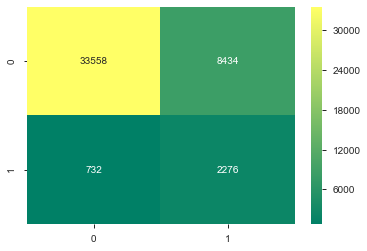

In [734]:
sns.heatmap(confusion_matrix(y_val, y_res_log), annot=True,
            fmt='3.0f', cmap="summer");

**RandomForestClassifier**

In [735]:
print(roc_auc_score(y_val, rf_par.predict_proba(X_valid_qt)[:,1]))

0.8621420900396934


In [736]:
y_pred = rf_par.predict_proba(X_valid_qt)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.533347


In [737]:
y_res = [1 if x > best_thresh else 0 for x in y_pred]

In [738]:
print(classification_report(y_res, y_val))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     34917
           1       0.76      0.23      0.35     10083

    accuracy                           0.81     45000
   macro avg       0.79      0.60      0.62     45000
weighted avg       0.80      0.81      0.77     45000



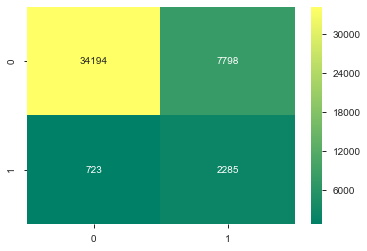

In [739]:
sns.heatmap(confusion_matrix(y_val, y_res), annot=True,
            fmt='3.0f', cmap="summer");

__Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

Создадим несколько дополнительных признаков на основе существующих. Их смысл понятен из названий.

In [744]:
df_train['NumberOfCredits_perPerson'] = df_train.NumberOfOpenCreditLinesAndLoans / (
    1 + df_train.NumberOfDependents)
df_train['NumberRealEstate_perPerson'] = df_train.NumberRealEstateLoansOrLines / (
    1 + df_train.NumberOfDependents)
df_train['MonthlyIncome_perPerson'] = df_train.MonthlyIncome / (
    1 + df_train.NumberOfDependents)

df_valid['NumberOfCredits_perPerson'] = df_valid.NumberOfOpenCreditLinesAndLoans / (
    1 + df_valid.NumberOfDependents)
df_valid['NumberRealEstate_perPerson'] = df_valid.NumberRealEstateLoansOrLines / (
    1 + df_valid.NumberOfDependents)
df_valid['MonthlyIncome_perPerson'] = df_valid.MonthlyIncome / (
    1 + df_valid.NumberOfDependents)

В датасете биннинг можно применять для создания признаков на основе значений количественных переменных, но, так как в исходном датасете ряд переменных не вызывает доверия по качеству заполнения, выберем только определенные. Исключение только для `MonthlyIncome`.  

In [617]:
# предикторы, у которых больше 10 уникальных значений
X_bin = df_train.loc[:, df_train.apply(pd.Series.nunique) > 10]
X_bin.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30_59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents',
       'NumberOfTimes_PastDue', 'MonthlyPayment', 'NumberOfCredits_perPerson',
       'NumberRealEstate_perPerson', 'MonthlyIncome_perPerson'],
      dtype='object')

In [745]:
# предполагаемые признаки для бинаризации
cols_for_bin = ['age', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
               'NumberRealEstateLoansOrLines', 'NumberOfTimes_PastDue', 
               'NumberOfDependents', 'NumberOfCredits_perPerson', 
               'NumberRealEstate_perPerson', 'MonthlyIncome_perPerson']

In [750]:
# Функция, вычисляющая IV по всем количественным предикторам
# из блокнота Романа Николаевича
# "Приложение 4_Пример предварительной подготовки данных в pandas"
#
# Полезная функция, особенно с учетом того, что пакетов на
# эту тему с хорошей документацией для python так и не нашла

def numeric_IV(df, y):
    iv_list = []
    df = df.copy()
    a = 0.0001
    target = y.astype('str')
    for var_name in cols_for_bin:
        df[var_name] = pd.qcut(
            df[var_name].values, 10, duplicates='drop').codes
        biv = pd.crosstab(df[var_name], target)
        IV = sum(((1.0 * biv['0'] / sum(biv['0']) + a) -
                  (1.0 * biv['1'] / sum(biv['1']) + a)) * np.log(
                      (1.0 * biv['0'] / sum(biv['0']) + a) /
                      (1.0 * biv['1'] / sum(biv['1']) + a)))
        iv_list.append(IV)
    col_list = list(cols_for_bin)
    result = pd.DataFrame({'Название переменной': col_list, 'IV': iv_list})
    result['Полезность'] = [
        'Подозрительно высокая' if x > 0.5 else 'Сильная'
        if x <= 0.5 and x > 0.3 else 'Средняя'
        if x <= 0.3 and x > 0.1 else 'Слабая'
        if x <= 0.1 and x > 0.02 else 'Бесполезная' for x in result['IV']
    ]
    return (result.sort_values(by='IV', ascending=False))

In [751]:
numeric_IV(df_train, y_tr)

,Название переменной,IV,Полезность
4,NumberOfTimes_PastDue,1.045307,Подозрительно высокая
0,age,0.240233,Средняя
6,NumberOfCredits_perPerson,0.115989,Средняя
1,MonthlyIncome,0.093143,Слабая
8,MonthlyIncome_perPerson,0.070850,Слабая
2,NumberOfOpenCreditLinesAndLoans,0.067259,Слабая
7,NumberRealEstate_perPerson,0.055377,Слабая
5,NumberOfDependents,0.023533,Слабая
3,NumberRealEstateLoansOrLines,0.013006,Бесполезная


"Подозрительно высокая" полезность переменной `NumberOfTimes_PastDue` логична, потому что количество просрочек в истории клиента напрямую связана с возможностью просрочек в будущем. Переменную `NumberOfDependents` исключим из списка на биннинг, т.к. уже были созданы бинарные переменные на ее основе.

In [752]:
# признаки для бинаризации
cols_for_bin = ['age', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
                'NumberRealEstateLoansOrLines', 'NumberOfTimes_PastDue',
                'NumberOfCredits_perPerson', 'NumberRealEstate_perPerson', 
                'MonthlyIncome_perPerson']

In [753]:
for var_name in cols_for_bin:
    df_train[f'{var_name}_bin'] = pd.cut(df_train[var_name], 10)
    df_valid[f'{var_name}_bin'] = pd.cut(df_valid[var_name], 10)

# если увеличить количество квантилей до 14, то полезность
# MonthlyIncome становится средней
df_train['MonthlyIncome_bin'] = pd.cut(df_train.MonthlyIncome, 14)
df_valid['MonthlyIncome_bin'] = pd.cut(df_valid.MonthlyIncome, 14)

In [754]:
df_train.head()
df_train.shape

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,NumberOfTimesLate_high,NumberOfTimesLate_96,NumberOfTimesLate_98,NumberOfTime30_59Days_none,NumberOfTimes90Days_none,NumberOfTime60_89Days_none,MonthlyPayment,MonthlyIncome_none,MonthlyIncome_zero,DebtRatio_zero,RUUL_high,RUUL_zero,RUUL_ones,NumberOfDependents_none,NumberOfCredits_perPerson,NumberRealEstate_perPerson,MonthlyIncome_perPerson,age_bin,MonthlyIncome_bin,NumberOfOpenCreditLinesAndLoans_bin,NumberRealEstateLoansOrLines_bin,NumberOfTimes_PastDue_bin,NumberOfCredits_perPerson_bin,NumberRealEstate_perPerson_bin,MonthlyIncome_perPerson_bin
138986,0.000000,49,0,0.127227,5163.0,5,0,0,0,0.0,0,0,0,0,1,1,1,656.872774,0,0,0,0,1,0,0,5.0,0.0,5163.0,"(47.4, 56.2]","(-1794.06, 128147.143]","(-0.058, 5.8]","(-0.054, 5.4]","(-0.294, 29.4]","(-0.058, 5.8]","(-0.054, 5.4]","(-1794.06, 179406.0]"
63965,0.033105,37,0,0.423063,2800.0,4,0,1,0,1.0,0,0,0,0,1,1,1,1184.576938,0,0,0,0,0,0,0,2.0,0.5,1400.0,"(29.8, 38.6]","(-1794.06, 128147.143]","(-0.058, 5.8]","(-0.054, 5.4]","(-0.294, 29.4]","(-0.058, 5.8]","(-0.054, 5.4]","(-1794.06, 179406.0]"
46078,0.007948,39,0,0.685663,3333.0,11,0,1,0,0.0,0,0,0,0,1,1,1,2285.314336,0,0,0,0,0,0,0,11.0,1.0,3333.0,"(38.6, 47.4]","(-1794.06, 128147.143]","(5.8, 11.6]","(-0.054, 5.4]","(-0.294, 29.4]","(5.8, 11.6]","(-0.054, 5.4]","(-1794.06, 179406.0]"
83031,0.576297,57,0,0.320077,15161.0,14,0,4,0,0.0,0,0,0,0,1,1,1,4852.679923,0,0,0,0,0,0,0,14.0,4.0,15161.0,"(56.2, 65.0]","(-1794.06, 128147.143]","(11.6, 17.4]","(-0.054, 5.4]","(-0.294, 29.4]","(11.6, 17.4]","(-0.054, 5.4]","(-1794.06, 179406.0]"
11185,0.623724,35,0,0.534226,6500.0,9,0,3,0,1.0,0,0,0,0,1,1,1,3472.465776,0,0,0,0,0,0,0,4.5,1.5,3250.0,"(29.8, 38.6]","(-1794.06, 128147.143]","(5.8, 11.6]","(-0.054, 5.4]","(-0.294, 29.4]","(-0.058, 5.8]","(-0.054, 5.4]","(-1794.06, 179406.0]"


(105000, 36)

In [755]:
cat_columns = [i for i in df_train.columns if 
               df_train[i].dtype.name=='category' or 
               df_train[i].dtype.name=='object']
num_columns = [i for i in df_train.columns if 
               df_train[i].dtype.name=='float64' or 
               df_train[i].dtype.name=='int64']

In [756]:
df_train_num = df_train[num_columns]

In [757]:
qtf.fit(df_train_num)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='normal', random_state=None,
                    subsample=100000)

In [758]:
X_train_plus = preproc(df_train, qtf)
X_valid_plus = preproc(df_valid, qtf)

In [759]:
X_train_plus.shape
X_train_plus.head()

(105000, 125)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,MonthlyPayment,NumberOfCredits_perPerson,NumberRealEstate_perPerson,MonthlyIncome_perPerson,NumberOfTimesLate_high_0,NumberOfTimesLate_high_1,NumberOfTimesLate_96_0,NumberOfTimesLate_96_1,NumberOfTimesLate_98_0,NumberOfTimesLate_98_1,NumberOfTime30_59Days_none_0,NumberOfTime30_59Days_none_1,NumberOfTimes90Days_none_0,NumberOfTimes90Days_none_1,NumberOfTime60_89Days_none_0,NumberOfTime60_89Days_none_1,MonthlyIncome_none_0,MonthlyIncome_none_1,MonthlyIncome_zero_0,MonthlyIncome_zero_1,DebtRatio_zero_0,DebtRatio_zero_1,RUUL_high_0,RUUL_high_1,RUUL_zero_0,RUUL_zero_1,RUUL_ones_0,RUUL_ones_1,NumberOfDependents_none_0,NumberOfDependents_none_1,"age_bin_(20.912, 29.8]","age_bin_(29.8, 38.6]","age_bin_(38.6, 47.4]","age_bin_(47.4, 56.2]","age_bin_(56.2, 65.0]","age_bin_(65.0, 73.8]","age_bin_(73.8, 82.6]","age_bin_(82.6, 91.4]","age_bin_(91.4, 100.2]","age_bin_(100.2, 109.0]","MonthlyIncome_bin_(-1794.06, 128147.143]","MonthlyIncome_bin_(128147.143, 256294.286]","MonthlyIncome_bin_(256294.286, 384441.429]","MonthlyIncome_bin_(384441.429, 512588.571]","MonthlyIncome_bin_(512588.571, 640735.714]","MonthlyIncome_bin_(640735.714, 768882.857]","MonthlyIncome_bin_(768882.857, 897030.0]","MonthlyIncome_bin_(897030.0, 1025177.143]","MonthlyIncome_bin_(1025177.143, 1153324.286]","MonthlyIncome_bin_(1153324.286, 1281471.429]","MonthlyIncome_bin_(1281471.429, 1409618.571]","MonthlyIncome_bin_(1409618.571, 1537765.714]","MonthlyIncome_bin_(1537765.714, 1665912.857]","MonthlyIncome_bin_(1665912.857, 1794060.0]","NumberOfOpenCreditLinesAndLoans_bin_(-0.058, 5.8]","NumberOfOpenCreditLinesAndLoans_bin_(5.8, 11.6]","NumberOfOpenCreditLinesAndLoans_bin_(11.6, 17.4]","NumberOfOpenCreditLinesAndLoans_bin_(17.4, 23.2]","NumberOfOpenCreditLinesAndLoans_bin_(23.2, 29.0]","NumberOfOpenCreditLinesAndLoans_bin_(29.0, 34.8]","NumberOfOpenCreditLinesAndLoans_bin_(34.8, 40.6]","NumberOfOpenCreditLinesAndLoans_bin_(40.6, 46.4]","NumberOfOpenCreditLinesAndLoans_bin_(46.4, 52.2]","NumberOfOpenCreditLinesAndLoans_bin_(52.2, 58.0]","NumberRealEstateLoansOrLines_bin_(-0.054, 5.4]","NumberRealEstateLoansOrLines_bin_(5.4, 10.8]","NumberRealEstateLoansOrLines_bin_(10.8, 16.2]","NumberRealEstateLoansOrLines_bin_(16.2, 21.6]","NumberRealEstateLoansOrLines_bin_(21.6, 27.0]","NumberRealEstateLoansOrLines_bin_(27.0, 32.4]","NumberRealEstateLoansOrLines_bin_(32.4, 37.8]","NumberRealEstateLoansOrLines_bin_(37.8, 43.2]","NumberRealEstateLoansOrLines_bin_(43.2, 48.6]","NumberRealEstateLoansOrLines_bin_(48.6, 54.0]","NumberOfTimes_PastDue_bin_(-0.294, 29.4]","NumberOfTimes_PastDue_bin_(29.4, 58.8]","NumberOfTimes_PastDue_bin_(58.8, 88.2]","NumberOfTimes_PastDue_bin_(88.2, 117.6]","NumberOfTimes_PastDue_bin_(117.6, 147.0]","NumberOfTimes_PastDue_bin_(147.0, 176.4]","NumberOfTimes_PastDue_bin_(176.4, 205.8]","NumberOfTimes_PastDue_bin_(205.8, 235.2]","NumberOfTimes_PastDue_bin_(235.2, 264.6]","NumberOfTimes_PastDue_bin_(264.6, 294.0]","NumberOfCredits_perPerson_bin_(-0.058, 5.8]","NumberOfCredits_perPerson_bin_(5.8, 11.6]","NumberOfCredits_perPerson_bin_(11.6, 17.4]","NumberOfCredits_perPerson_bin_(17.4, 23.2]","NumberOfCredits_perPerson_bin_(23.2, 29.0]","NumberOfCredits_perPerson_bin_(29.0, 34.8]","NumberOfCredits_perPerson_bin_(34.8, 40.6]","NumberOfCredits_perPerson_bin_(40.6, 46.4]","NumberOfCredits_perPerson_bin_(46.4, 52.2]","NumberOfCredits_perPerson_bin_(52.2, 58.0]","NumberRealEstate_perPerson_bin_(-0.054, 5.4]","NumberRealEstate_perPerson_bin_(5.4, 10.8]","NumberRealEstate_perPerson_bin_(10.8, 16.2]","NumberRealEstate_perPerson_bin_(16.2, 21.6]","NumberRealEstate_perPerson_bin_(21.6, 27.0]","NumberRealEstate_perPerson_bin_(27.0, 32.4]","NumberRealEstate_perPerson_bin_(32.4, 37.8]","NumberRealEstate_perPerson_bin

**LogisticRegression**

In [760]:
%%time
logit_plus = LogisticRegression(class_weight='balanced', n_jobs=-1)
logit_plus.fit(X_train_plus, y_tr)

Wall time: 24 s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [761]:
%%time
scores_logit_plus = cross_val_score(logit_plus, X_train_plus, y_tr, 
                                   scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки после подбора "
      "параметра 'C' LogisticRegression: {}".format(scores_logit_plus))
scores_logit_plus.mean()

Значения правильности перекрестной проверки после подбора параметра 'C' LogisticRegression: [0.86679636 0.85834321 0.85669847 0.85081793 0.84309331 0.84781198
 0.87521248 0.85413399 0.86237074 0.85530712]
Wall time: 3min 32s


0.8570585600450281

**RandomForestClassifier**

In [762]:
%%time
rf_plus = RandomForestClassifier(class_weight='balanced_subsample',
                                 max_depth=8, criterion='entropy',
                                 max_features=X_train_plus.shape[1],
                                 n_estimators=1200, n_jobs=-1, 
                                 random_state=2020)
rf_plus.fit(X_train_plus, y_tr)

Wall time: 2min 35s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, max_features=125, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1200, n_jobs=-1, oob_score=False,
                       random_state=2020, verbose=0, warm_start=False)

In [763]:
%%time
scores_rf_plus = cross_val_score(rf_plus, X_train_plus, y_tr,
                                 scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки: {}".format(scores_rf_plus))
scores_rf_plus.mean() 

Значения правильности перекрестной проверки: [0.8710745  0.86152063 0.86359403 0.85255007 0.84540954 0.85212067
 0.87711167 0.85050964 0.86271895 0.86311062]
Wall time: 22min 37s


0.8599720321713843

Относительно базовых моделей (без подбора параметров) метрики немного улучшились. Хотя в отношении `RandomForestClassifier` это, конечно, несколько лукаво звучит, потому что некоторые важные параметры были указаны.

Подбирать параметры будем в несколько сокращенном виде.

In [767]:
%%time
def hyperopt_logit_score(params):
    clf = LogisticRegression(**params, class_weight='balanced', n_jobs=-1)
    
    current_score = cross_val_score(
        clf, X_train_plus, y_tr, scoring=ftwo_scorer, cv=skf).mean()
    print(current_score, params)
    return -current_score

logit_space = {
    'C': hp.uniform('C', 0.01, 120)
}

best = fmin(
    fn=hyperopt_logit_score, space=logit_space, algo=tpe.suggest, max_evals=25)
print('best:')
print(best)

0.8570721245502053                                                             
{'C': 26.6568088739437}                                                        
0.8570301580108323                                                             
{'C': 75.00659438194808}                                                       
0.8570888583141452                                                             
{'C': 89.11435223128952}                                                       
0.8570733365687904                                                             
{'C': 34.11751522844876}                                                       
0.8570572157561707                                                             
{'C': 85.45457273482641}                                                       
0.85706407164752                                                               
{'C': 75.5867159413821}                                                        
0.8570729308752595                      

In [766]:
%%time
def hyperopt_forest_score(params):
    clf = RandomForestClassifier(
        **params,
        random_state=42,
        class_weight='balanced_subsample',
        max_features=X_train_plus.shape[1],
        criterion='entropy',
        n_jobs=-1)
    
    current_score = cross_val_score(
        clf, X_train_plus, y_tr, scoring=ftwo_scorer, cv=skf).mean()
    
    print(current_score, params)
    return -current_score

space_forest = {
    'max_depth': hp.choice('max_depth', range(2, 16)),
    'n_estimators': ho_scope.int(hp.quniform('n_estimators', 
                                             600, 1500, 5))
}

best = fmin(
    fn=hyperopt_forest_score,
    space=space_forest,
    algo=tpe.suggest,
    max_evals=25)
print('best:')
print(best)

0.8608575933139188                                                             
{'max_depth': 6, 'n_estimators': 975}                                          
0.8541339554165986                                                             
{'max_depth': 3, 'n_estimators': 1380}                                         
0.8582860372469368                                                             
{'max_depth': 9, 'n_estimators': 1380}                                         
0.8483689804819269                                                             
{'max_depth': 13, 'n_estimators': 750}                                         
0.8560562944685353                                                             
{'max_depth': 10, 'n_estimators': 795}                                         
0.8535498861741374                                                             
{'max_depth': 11, 'n_estimators': 1295}                                        
0.8608339865939856                      

In [769]:
gc.collect()

11761

Как улучшилось качество модели?

**LogisticRegression**

In [768]:
%%time
logit_res = LogisticRegression(class_weight='balanced', n_jobs=-1,
                               C=115.69905892266506)
logit_res.fit(X_train_plus, y_tr)

Wall time: 24.2 s


LogisticRegression(C=115.69905892266506, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [770]:
%%time
scores_logit_res = cross_val_score(logit_res, X_train_plus, y_tr, 
                                   scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки после подбора "
      "параметра 'C' LogisticRegression: {}".format(scores_logit_res))
scores_logit_res.mean()

Значения правильности перекрестной проверки после подбора параметра 'C' LogisticRegression: [0.86716336 0.85870818 0.85665849 0.85064609 0.84321906 0.84792699
 0.87515884 0.85412658 0.86270441 0.85497084]
Wall time: 3min 22s


0.8571282826694633

In [771]:
print(roc_auc_score(y_val, logit_res.predict_proba(X_valid_plus)[:,1]))

0.8573003187917252


In [772]:
y_pred_log_res = logit_res.predict_proba(X_valid_plus)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_log_res)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.498122


In [773]:
y_res_logit_res = [1 if x > best_thresh else 0 for x in y_pred_log_res]

In [774]:
print(classification_report(y_res_logit_res, y_val))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87     33705
           1       0.77      0.20      0.32     11295

    accuracy                           0.78     45000
   macro avg       0.78      0.59      0.60     45000
weighted avg       0.78      0.78      0.73     45000



Logistic Regression


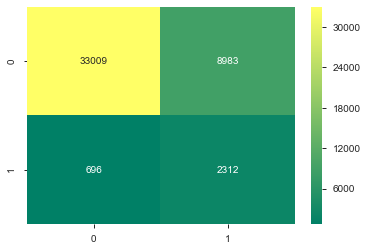

In [775]:
print('Logistic Regression')
sns.heatmap(confusion_matrix(y_val, y_res_logit_res), annot=True,
            fmt='3.0f', cmap="summer")
pass;

**RandomForestClassifier**

In [776]:
%%time
rf_res = RandomForestClassifier(class_weight='balanced_subsample',
                                 max_depth=6, criterion='entropy',
                                 max_features=X_train_plus.shape[1],
                                 n_estimators=975, n_jobs=-1, 
                                 random_state=2020)
rf_res.fit(X_train_plus, y_tr)

Wall time: 1min 39s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, max_features=125, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=975, n_jobs=-1, oob_score=False,
                       random_state=2020, verbose=0, warm_start=False)

In [777]:
%%time
scores_rf_res = cross_val_score(rf_res, X_train_plus, y_tr,
                                 scoring='roc_auc', cv=skf)
print("Значения правильности перекрестной проверки: {}".format(scores_rf_res))
scores_rf_res.mean() 

Значения правильности перекрестной проверки: [0.87254959 0.86183341 0.86395742 0.85270026 0.84669461 0.85298732
 0.87750458 0.85250856 0.86453199 0.8630481 ]
Wall time: 14min 25s


0.8608315855219895

In [778]:
print(roc_auc_score(y_val, rf_res.predict_proba(X_valid_plus)[:,1]))

0.862102434246594


In [661]:
y_pred_rf_res = rf_res.predict_proba(X_valid_plus)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf_res)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.398201


In [662]:
y_rf_res = [1 if x > best_thresh else 0 for x in y_pred_rf_res]

In [663]:
print(classification_report(y_rf_res, y_val))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86     32422
           1       0.81      0.19      0.31     12578

    accuracy                           0.76     45000
   macro avg       0.78      0.59      0.58     45000
weighted avg       0.77      0.76      0.70     45000



Random Forest


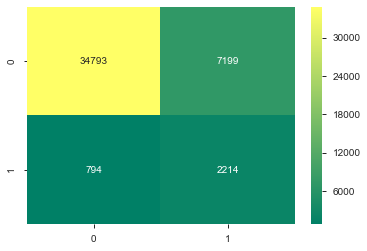

In [714]:
print('Random Forest')
sns.heatmap(confusion_matrix(y_val, y_rf_res), annot=True,
            fmt='3.0f', cmap="summer");

В результате добавления признаков (в том числе за счет бинаризации) качество моделей немного улучшилось на обучающей выборке, но на валидационной даже чуть упало, что говорит о переобучении.

In [779]:
with open('models/rf_res.pkl', 'wb') as file:  
    pickle.dump(rf_res, file)
with open('models/logit_res.pkl', 'wb') as file:  
    pickle.dump(logit_res, file)

__Кривые валидации и обучения__

In [652]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Анализ проведен для первой модели (с меньшим количеством параметров) из-за длительности обработки. 

<module 'matplotlib.pyplot' from 'C:\\Users\\NatalyR\\Anaconda3\\envs\\mystudy\\lib\\site-packages\\matplotlib\\pyplot.py'>

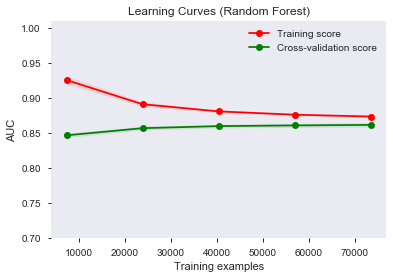

In [653]:
%%time
title = "Learning Curves (Random Forest)"
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

estimator = RandomForestClassifier(class_weight='balanced_subsample', 
                                max_depth=6, criterion='entropy', 
                                max_features=X_train_qt.shape[1], 
                                n_estimators=1164, n_jobs=-1, 
                                random_state=2020)
plot_learning_curve(estimator, title, X_train_qt, y_tr, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

С помощью `validation_curve` можно оценить влияние одного гиперпараметра на значения метрик обучающего и валидационного набора.

Оценка влияния гиперпараметра `max_depth`:

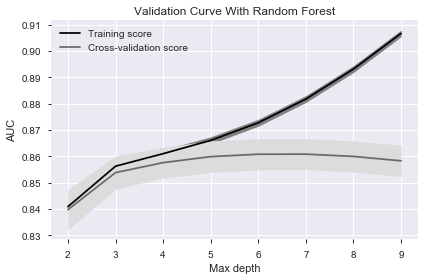

Wall time: 27min 59s


In [702]:
%%time
param_range = np.arange(2, 10, 1)

train_scores, test_scores = validation_curve(
    rf_par,
    X_train_qt,
    y_tr,
    param_name='max_depth',
    param_range=param_range,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(
    param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(
    param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(
    param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Max depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Какие наилучшие параметры модели по результатам построения?
Как можно улучшить модель?

Данных точно больше не нужно судя по кривой обучения.

Результат на кросс-валидации показывает, что не имеет смысла увеличивать максимальную глубину деревьев большее 6. Анализ проведен для первой модели (с меньшим количеством параметров) из-за длительности обработки. 

__Оценка модели с описанием выбранной метрики__

In [701]:
features = list(X_valid_qt.columns)

In [700]:
# Коэффициенты и признаки
list(zip(logit_par.coef_[0], X_valid_qt.columns))

[(0.8821345976533553, 'RevolvingUtilizationOfUnsecuredLines'),
 (-0.2114274044379437, 'age'),
 (0.20344252965469706, 'NumberOfTime30_59DaysPastDueNotWorse'),
 (-0.034070994414615044, 'DebtRatio'),
 (-0.178228112331585, 'MonthlyIncome'),
 (0.09715497255933894, 'NumberOfOpenCreditLinesAndLoans'),
 (0.14304041427539885, 'NumberOfTimes90DaysLate'),
 (-0.04867557334904105, 'NumberRealEstateLoansOrLines'),
 (0.07765276526083412, 'NumberOfTime60_89DaysPastDueNotWorse'),
 (0.009617723386241195, 'NumberOfDependents'),
 (0.17558113225308256, 'NumberOfTimes_PastDue'),
 (0.3005941072818969, 'MonthlyPayment'),
 (0.6214828518087993, 'NumberOfTimesLate_high_0'),
 (-0.30285567171915506, 'NumberOfTimesLate_high_1'),
 (0.31368293259008345, 'NumberOfTimesLate_96_0'),
 (0.004944247499571225, 'NumberOfTimesLate_96_1'),
 (0.6264270993083799, 'NumberOfTimesLate_98_0'),
 (-0.30779991921873295, 'NumberOfTimesLate_98_1'),
 (-0.4590818311600671, 'NumberOfTime30_59Days_none_0'),
 (0.7777090112497038, 'NumberOfTim

__Общие выводы__

По результатам проведенного анализа, можно увидеть, что есть определенные зависимости и признаки просрочки кредита. 
Наблюдаются следующие закономерности - клиент с более высоким месячным доходом с бОльшей вероятностью выплачивает кредит вовремя. 

Вероятности просрочки кредита у клиентов прямо зависит от степени "закредитованности" (переменная `RevolvingUtilizationOfUnsecuredLines`). 

Имеет влияние наличие предыдущих просрочек - с ростом их количества заемщик становиться менее привлекательным в связи с высокой вероятностью новой просрочки.

Также влияет и количество иждивенцев в семье заемщика - клиент с бОльшим количеством иждивенцев с бОльшей вероятностью не выплачивает кредит вовремя. 

В дальнейшем, можно добавить синтетические данные, чтобы увеличить количество наблюдений для миноритарного класса.

Также можно заменить случайный лес на стекинг нескольких моделей, например, `RandomForestClassifier`, `SVC`, `xgboost` (могут быть разные варианты).